# Modeling Relationships

In this section, we’ll explore how to build complex relationships between entities using a combination of uniqueness constraints and referential constraints.

## Uniqueness Constraints

Uniqueness constraints are typically set through primary keys, but tables can also have additional unique indexes beyond the primary key.

## Referential Constraints

Referential constraints establish relationships between tables and are enforced by [foreign keys](030-foreign-keys.ipynb).

## Foreign Keys Establish 1:1 or 1:N Relationships

When a child table defines a foreign key constraint to a parent table, it creates a relationship between the entities in the parent and child tables. The cardinality of this relationship is always **1 on the parent side**: each entry in the child table must refer to a single entity in the parent table.

On the child side, the relationship can have different cardinalities:

- **0–1**: if the foreign key field in the child table has a unique constraint.
- **N**: if no uniqueness constraint is applied to the foreign key field.

Let’s illustrate these possibilities with examples of bank customers and their accounts.


In [32]:
import datajoint as dj

## Example: 1:N Relationship

In the first example, let the rule be that customers are independent entities and accounts have exactly one owner but customers can have any number of accounts.
This is an example of an 1:N relationship between customers and their accounts.

Then the foreign key is declared in the `Account` table.

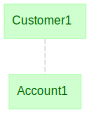

In [33]:
schema1 = dj.Schema('bank1')
@schema1
class Customer1(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned
    unique index(ssn)
    """

@schema1
class Account1(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> Customer1
    open_date : date
    """

dj.Diagram(schema1)

In this design:

* Each account is linked to a single customer through a foreign key referencing the primary key in Customer1, ensuring that each account has one, and only one, owner.
* This setup allows each customer to own multiple accounts, as there is no unique constraint on the foreign key in Account1.
* Customers may have zero or more accounts, as there’s no requirement for every customer to have an associated account.
* Every account must have an owner, since the foreign key reference to Customer1 is mandatory (non-nullable).

This structure establishes a one-to-many relationship between customers and accounts: one customer can own multiple accounts, but each account belongs to only one customer.

To allow some accounts without an assigned owner, we can modify the design to make the foreign key nullable:

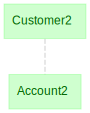

In [34]:
schema2 = dj.Schema('bank2')
@schema2
class Customer2(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned
    unique index(ssn)
    """

@schema2
class Account2(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> [nullable] Customer2
    open_date : date
    """

dj.Diagram(schema2)

In this modified design:

* Accounts without owners are allowed by setting the foreign key to Customer2 as nullable.
* The schema diagram does not visually distinguish between required and optional dependencies, so the nullable nature of the foreign key is not visible in the diagram.
* This configuration supports cases where accounts may or may not be assigned to a customer, adding flexibility to the data model.

Consider a third design where the foreign key is part of a composite primary key:

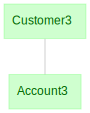

In [35]:
schema3 = dj.Schema('bank3')

@schema3
class Customer3(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema3
class Account3(dj.Manual):
    definition = """
    -> Customer3
    account : int unsigned
    ---
    open_date : date
    """

dj.Diagram(schema3)

In this design:

* Composite Primary Key: The primary key for `Account3` is a combination of `customer_id` and `account`, meaning each account is uniquely identified by both the customer and account number together and neither of the two fields separately has to be unique across accounts.
* One-to-Many Relationship: Since `customer_id` is only part of the primary key (not the entire primary key), it doesn’t need to be unique within `Account3`. This allows each customer to have multiple accounts, preserving the one-to-many relationship between Customer3 and Account3.
* Foreign Key Reference: The foreign key to `Customer3` establishes the relationship, ensuring that each entry in Account3 references a valid customer in Customer3.

This setup maintains the one-to-many relationship while allowing for each account to be uniquely identified by a combination of customer and account identifiers.

In the diagram, solid lines indicate a dependency where the foreign key is part of the primary key, signifying a stronger relationship than a secondary reference. This stronger relationship ensures that any foreign keys pointing to `Account3` will also transitively reference `Customer3`.

### Exercise: Analyzing Bank Design

Review the database design below and consider how this structure might reflect the bank’s operations.

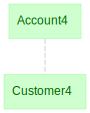

In [36]:
schema4 = dj.Schema('bank4')

@schema4
class Account4(dj.Manual):
    definition = """
    account : int unsigned
    ---
    open_date : date
    """


@schema4
class Customer4(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    -> Account4
    """


dj.Diagram(schema4)

### Interpretation
Consider the implications of this setup:

* Each customer entry contains a reference to a single account in `Account4`, suggesting that each customer is linked to one specific account.
* Since there is no constraint on the number of customers who can point to the same account, this design may allow multiple customers to be associated with a single account, indicating the possibility of shared accounts.
* However, the structure does not allow an customer to exist without being associated with an account, as each customer record must reference an existing account.

These choices might reflect the bank’s operations and policies, such as whether joint accounts are supported, and how account ownership is managed.

## One-to-One Relationships

A one-to-one relationship is created when a foreign key in the child table is also designated as either the primary key or a unique index. This ensures that each entry in the child table corresponds to a single, unique entry in the parent table, and no parent entry is linked to more than one child entry.

In a one-to-one relationship, the connection is always optional on the child side: a child entry is not required for every parent entry. Therefore, the cardinality on the child side is 0..1—each parent may have either zero or one associated child entry.

In the following example, the foreign key in `Account` is also its primary key, resulting in a one-to-one relationship:

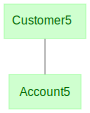

In [37]:
schema5 = dj.Schema('bank5')

@schema5
class Customer5(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema5
class Account5(dj.Manual):
    definition = """
    -> Customer5
    ---
    open_date : date
    """

dj.Diagram(schema5)

The diagramming notation represents this relationship with a thick solid line, which indicates the strongest type of dependency between two entities.
In this setup, `Customer5` and `Account5` share the same identity because `Account5` inherits its primary key from `Customer5`.
This setup creates a strict one-to-one relationship between Customer5 and Account5, where each account is uniquely and exclusively linked to a single customer.

### Characteristics of This Structure
* **Unified Identity:** Since `Account5` shares the primary key with `Customer5`, each `Account5` record is uniquely identified by the same key as `Customer5`.
This enforces the rule that each account cannot exist without an associated customer.

* **Conflated Entities:** In the diagram, the name `Account5` is no longer underscored, indicating it has ceased to function as a separate “dimension” or independent entity. `Account5` is now fully conflated with `Customer5`, meaning it effectively serves as an extension of the `Customer5` entity, rather than an independent table with its own identity.

### Why Keep Separate Tables?
Although this design could allow us to simply merge all account-related data into the `Customer5` table, there are reasons we may choose to keep `Account5` as a separate table:

1. **Modularity and Clarity**: Separating `Account5` from `Customer5` keeps the structure modular, which can clarify different aspects of customer and account data in queries and during development.

2. **Data Management**: By keeping account information in a separate table, we can manage and update account-related data independently from customer information. This separation can be beneficial for tasks such as auditing, logging, or updating fields associated with only account data.

3. **Avoiding Optional Fields**: In cases where certain fields are only relevant to accounts (e.g., open_date, account-specific details), keeping them in a separate table prevents having unused or irrelevant fields in the main `Customer5` table.

4. **Access Control**: When account information is sensitive or needs restricted access, placing it in a separate table can simplify access control, allowing finer-grained security policies around account data.

5. **Scalability and Maintenance**: Over time, this separation can support scalability as customer and account data expand. If we anticipate adding extensive account-specific data or if account records will be managed differently from customer records, the separate tables facilitate maintenance and future-proof the structure.

6. **Schema Evolution**: Separate tables provide flexibility to adapt or expand either the Customer5 or Account5 table independently, without altering the other table. This flexibility is especially useful if the schema is expected to evolve over time.

Another approach to establishing a one-to-one relationship is to use a secondary foreign key with an additional uniqueness constraint. DataJoint’s foreign key syntax supports both `unique` and `nullable` modifiers on foreign keys, providing flexibility in how relationships are structured.

* **`unique` Modifier**: Adding the unique modifier to a foreign key converts a one-to-many relationship into a one-to-one relationship. This ensures that each entry in the child table corresponds to only one entry in the parent table and vice versa, enforcing a strict one-to-one link.

* **`nullable` Modifier**: The `nullable` modifier allows the relationship to be optional on the child side, meaning that not every child entry must reference a parent entry. (Relationships are already optional on the parent side, as parent entries don’t depend on children.)

### Example: One-to-One Relationship with Unique and Nullable Modifiers
The following example demonstrates how to model a one-to-one relationship using a secondary unique constraint:

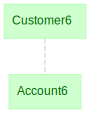

In [39]:

schema6 = dj.Schema('bank6')

@schema6
class Customer6(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    full_name : varchar(30)
    ssn = null : int unsigned  # Optional SSN with unique constraint
    unique index(ssn)
    """

@schema6
class Account6(dj.Manual):
    definition = """
    account : int unsigned
    ---
    -> [unique, nullable] Customer6
    open_date : date
    """

dj.Diagram(schema6)